### Import data set from Kaggle

In [1]:
import opendatasets as od
od.download("https://www.kaggle.com/hsankesara/flickr-image-dataset/code")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jakobbruchhausen
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.16G/8.16G [05:16<00:00, 27.7MB/s]


### Import dependancies

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import shutil
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torch import nn
import matplotlib.pyplot as plt
import torch
from itertools import chain
from PIL import Image

### Data loading and handling

In [4]:
all_img_path = Path.cwd() / "flickr-image-dataset/flickr30k_images"
all_img_filenames = list(all_img_path.glob("*.jpg"))
train_filenames, testval_filenames = train_test_split(all_img_filenames, test_size=0.2, random_state=1)
val_filenames, test_filenames = train_test_split(testval_filenames, test_size=0.5, random_state=1)

subdirectories = {"train": train_filenames,
                  "val": val_filenames,
                  "test": test_filenames,
                 }

for subdirectory in subdirectories.keys():
    subdirectory = Path(subdirectory)
    subdirectory.mkdir(parents=True, exist_ok=True)
    
def fill_sub_dir(sub_dir, file_subset):
    
    for file in file_subset:
        file_path = Path.cwd() / sub_dir / file.name
        shutil.copyfile(file, file_path)
        
for sub_dir, file_subset in subdirectories.items():
    fill_sub_dir(sub_dir, file_subset)

In [3]:
class ImgData(Dataset):
    
    def __init__(self, root, transform_grayscale, transform_color):
        """Constructor
        
        Args:
            root (Path/str): Filepath to the data root, e.g. './small_train'
            transform (Compose): A composition of image transforms, see below.
        """
        
        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")
            
        self.root = root
        self.transform_grayscale = transform_grayscale
        self.transform_color = transform_color
        
        # Collect samples, both cat and dog and store pairs of (filepath, label) in a simple list.
        self._samples = self._collect_imgs_sub_dir(self.root)
            
    def __getitem__(self, index):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample (Tensor, int)
        """
        # Access the stored path and label for the correct index
        path = self._samples[index]
        # Load the image into memory
        gray_img = Image.open(path)
        c_img = Image.open(path)
        
        # Perform transforms, if any.
        if self.transform_grayscale is not None:
            gray_img = self.transform_grayscale(gray_img)
            
        if self.transform_color is not None:
            c_img = self.transform_color(c_img)
            
        return gray_img, c_img
    
    def __len__(self):
        """Total number of samples"""
        return len(self._samples)
    
    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory
        
        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return list(sub_dir.glob("*.jpg"))
    
example_dataset = ImgData("./train", transform_grayscale=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                                             transforms.ToTensor()]), 
                          transform_color=transforms.ToTensor())

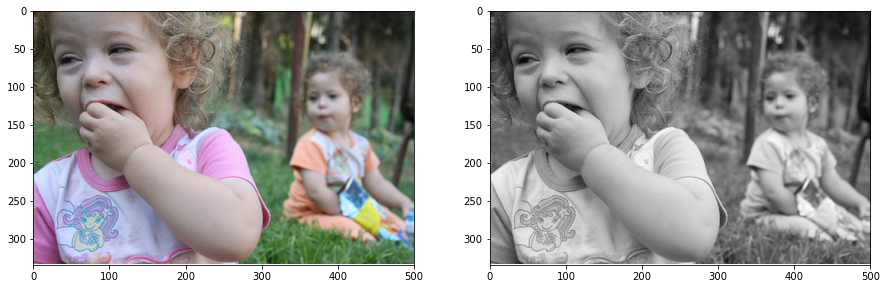

In [4]:
def display_image(axis1, axis2, image_1, image_2):
    """Display a tensor as an image
    
    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
    """
    
    if not isinstance(image_1, torch.Tensor):
        raise TypeError("The `display_image` function expects a `torch.Tensor` " +
                        "use the `ToTensor` transformation to convert the images to tensors.")

    image_data_1 = image_1.permute(1, 2, 0).detach().cpu().numpy()
    image_data_2 = image_2.permute(1, 2, 0).detach().cpu().numpy()
    height1, width1, _ = image_data_1.shape
    height2, width2, _ = image_data_2.shape

    if image_data_1.shape[2] == 1:
        axis1.imshow(image_data_1, cmap='gray')
    else:
        axis1.imshow(image_data_1)
        
    if image_data_2.shape[2] == 1:
        axis2.imshow(image_data_2, cmap='gray')
    else:
        axis2.imshow(image_data_2)
    
    axis1.set_xlim(0, width1)
    axis2.set_xlim(0, width2)
    axis1.set_ylim(height1, 0)
    axis2.set_ylim(height2, 0)


_, (axis1, axis2) = plt.subplots(1,2, figsize=(15,15))
some_random_index = np.random.randint(25000)
some_random_index = 32
gray_image, color_image = example_dataset[some_random_index]
display_image(axis1, axis2, color_image, gray_image)




### Data pre-processing

In [5]:
# create greyscale data loaders for training, validataion and test data
img_size = 224
batch_size = 16
num_workers=0

transform_grayscale = transforms.Compose([transforms.Resize((img_size,img_size)) , 
                                transforms.Grayscale(num_output_channels=1), 
                                transforms.ToTensor()])
transform_color = transforms.Compose([transforms.Resize((img_size,img_size)), 
                                transforms.ToTensor()])

train_dataloader = DataLoader(ImgData("./train", transform_grayscale=transform_grayscale,
                                     transform_color=transform_color),
                                   batch_size=batch_size,
                                   shuffle=True,
                                     num_workers=num_workers)
val_dataloader = DataLoader(ImgData("./val", transform_grayscale=transform_grayscale,
                                     transform_color=transform_color),
                                   batch_size=batch_size,
                                   shuffle=True,
                                     num_workers=num_workers)
test_dataloader = DataLoader(ImgData("./test", transform_grayscale=transform_grayscale,
                                     transform_color=transform_color),
                                   batch_size=batch_size,
                                   shuffle=True,
                                     num_workers=num_workers)


### Creating the model

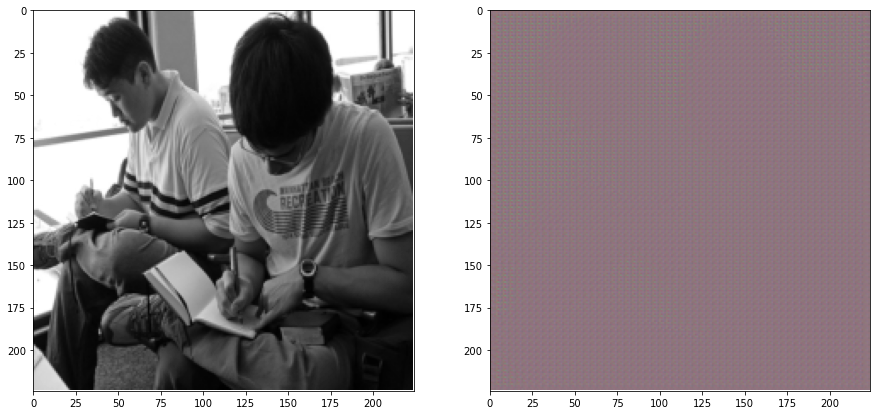

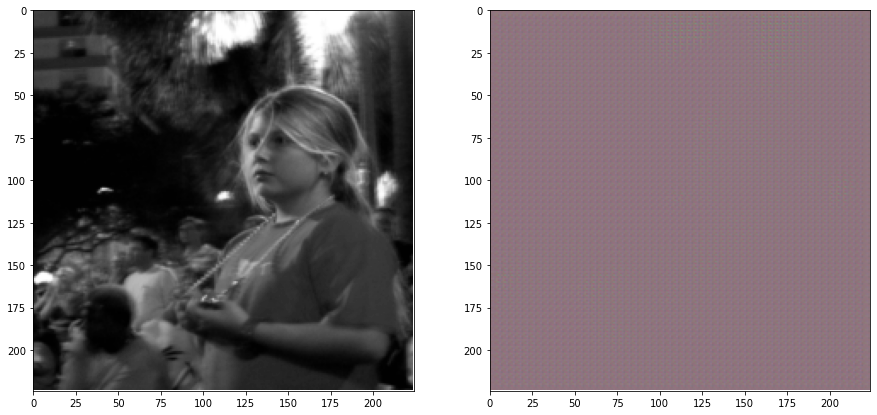

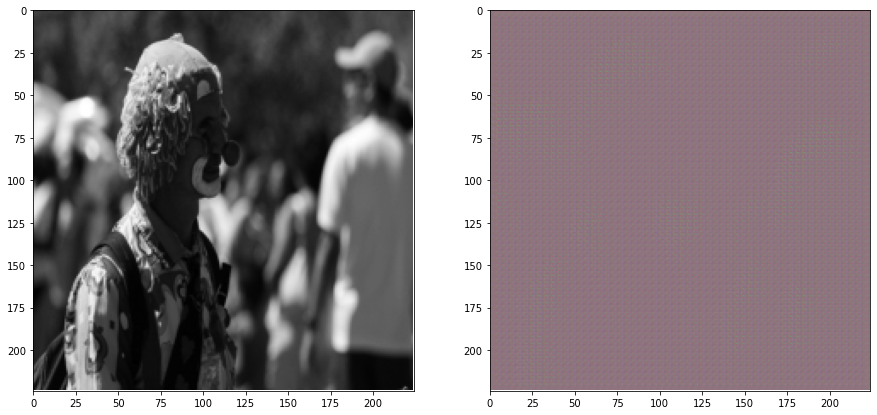

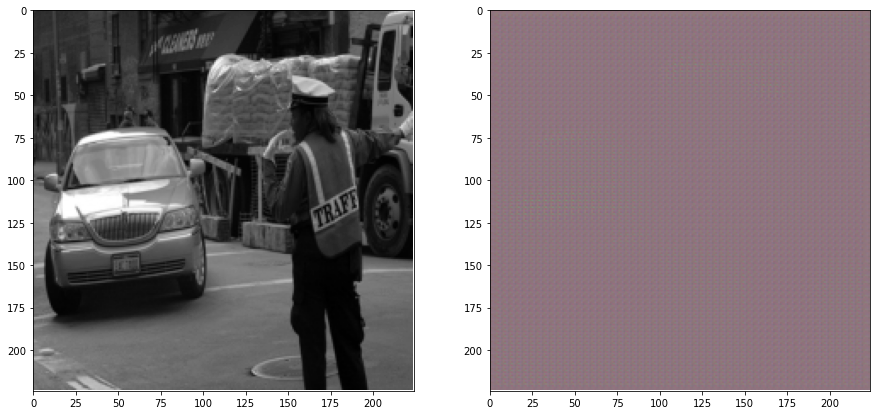

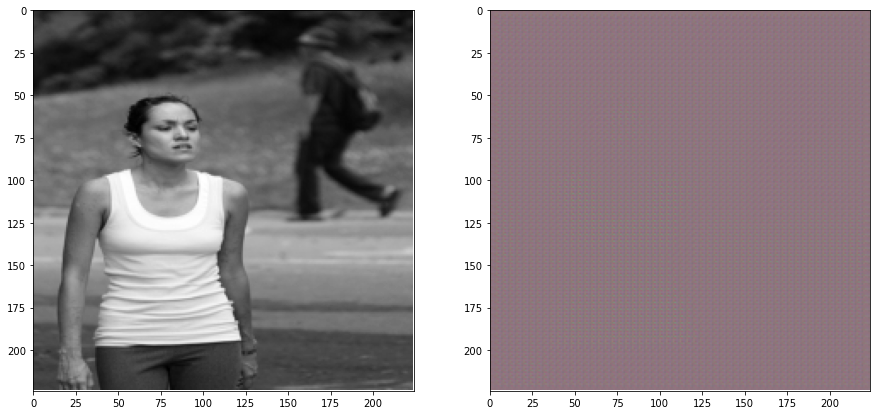

In [37]:
class ColorizationNetwork(nn.Module):
    def __init__(self):
        super(ColorizationNetwork, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, 2, stride=2, padding=0),
            nn.Conv2d(32, 64, 4, stride=2, padding=0),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=0),
            nn.ConvTranspose2d(32, 3, 2, stride=2, padding=0)
        )
                
    def forward(self, input_batch):
        logits = self.conv_stack(input_batch)
        return torch.sigmoid(logits)

test_network = ColorizationNetwork()


for batch, (x,y) in enumerate(train_dataloader, 1):
    log = test_network.forward(x)
    for i in range(5):
        _, (axis1, axis2) = plt.subplots(1,2, figsize=(15,15))
        display_image(axis1, axis2, x[i], log[i])
    break




### Defining training loop

In [9]:
def training(model, optimizer, loss_fn, batch_size, train_loader, val_loader, num_epocs, val_freq):
    print("---------------------------")
    print("---- Starting training ----")
    print("---------------------------")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    print(device)
    model.to(device)
    
    train_loss_list, val_loss_list = [], []
    train_t, val_t = [], []
    
    print("Validation...")
    model.eval()
    val_loss = validate(model, loss_fn, val_loader, device)
    val_loss_list.append(val_loss)
    val_t.append(0)
    
    # training over epochs
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs}:")
        
        num_batches = len(train_loader)

        # iterating over all batches and training samples
        for batch, (x, y) in enumerate(train_loader, 1):
            
            print(f"Progress, batch {batch}/{num_batches}", end='\r')
            
            model.train()
            X, trueImg = x.to(device), y.to(device)
            fused_logits = torch.zeros(len(X), 512, 28, 28).to(device)
            optimizer.zero_grad()
            output = model.forward(X, fused_logits)
            loss = loss_fn(output, trueImg)
            loss.backward()
            optimizer.step()
            del X, trueImg, output

            
            print(f"\n{loss.item()}\n")
            
            train_loss_list.append(loss.item())
            train_t.append(batch / num_batches + epoch)
            
                
            if val_freq is not None and batch % val_freq == 0:
                model.eval()
                print("Validation...")
                val_loss = validate(model, loss_fn, val_loader, device)
                model.train()
                val_loss_list.append(val_loss)
                val_t.append(batch / batch_size + epoch)
                
                print(f"Epoch {epoch}/{num_epochs}: \n"
                      f"Train loss: {sum(train_loss_list)/len(train_loss_list):.4f}, "
                      f"Val. loss: {val_loss:.4f}")
        print("\n")
        print("Validation...")
        model.eval()
        val_loss = validate(model, loss_fn, val_loader, device)
        val_loss_list.append(val_loss)
        val_t.append(epoch+1)     
                
        print(f"Epoch {epoch+1}/{num_epochs}: \n"
              f"Train loss: {sum(train_loss_list)/len(train_loss_list):.4f}, "
              f"Val. loss: {val_loss:.4f}") 
        
    print("---------------------------")
    print("----- Ending training -----")
    print("---------------------------")
                          
    return model, train_loss_list, val_loss_list, train_t, val_t

        
def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    model.eval()
    num_valbatches = len(val_loader)
    with torch.no_grad():
        for batch, (x, y) in enumerate(val_loader, 1):
            print(f"Evaluation in progress, batch: {batch}/{num_valbatches}", end='\r')
            X, trueImg = x.to(device), y.to(device)
            fused_logits = torch.zeros(len(x), 512, 28, 28).to(device)
            output = model.forward(X, fused_logits)
            batch_loss = loss_fn(output, trueImg)
            del X, trueImg, output
            
            val_loss_cum += batch_loss.item()
        val_loss_cum /= len(val_loader)
        print("\n")
            
    return val_loss_cum

    

In [ ]:
net = ColorizationNetwork()
learning_rate = .01
loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
num_epochs = 2

model, train_loss_list, val_loss_list, train_t, val_t = training(net,
                                                                 optimizer, 
                                                                 loss_fn, 
                                                                 batch_size, 
                                                                 train_dataloader, val_dataloader, 
                                                                 num_epochs, val_freq=None)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for batch, (x,y) in enumerate(train_dataloader, 1):
    log = net.forward(x.to(device))
    for i in range(5):
        _, (axis1, axis2) = plt.subplots(1,2, figsize=(15,15))
        display_image(axis1, axis2, y[i], log[i])
    break

In [ ]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.plot(train_t, train_loss_list)
ax2.plot(val_t, val_loss_list)
plt.show()


### Creating new network with feature fusion


In [2]:
t = torch.cuda.get_device_properties(0).total_memory
#r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
print(t)
print(a)
print(t-a)

4294967296
0
4294967296


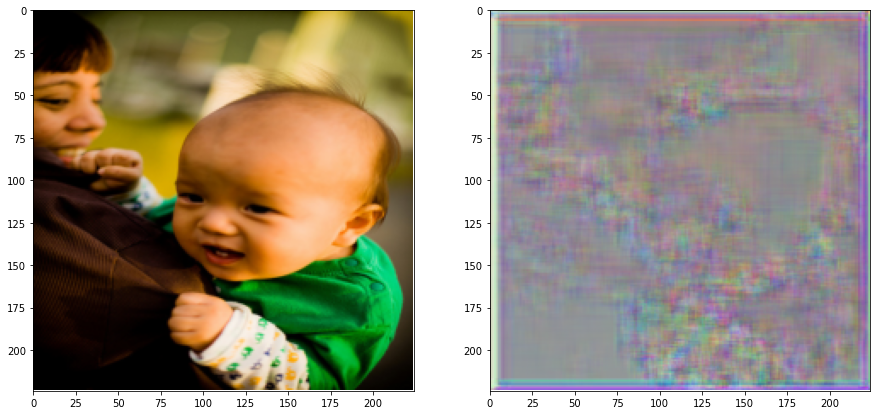

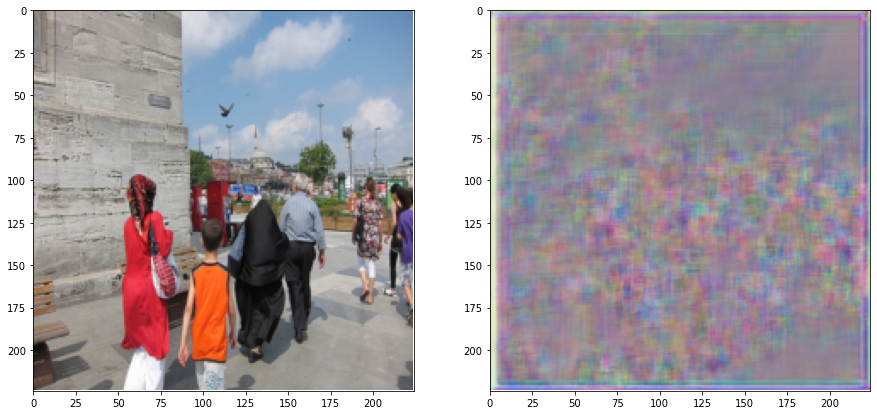

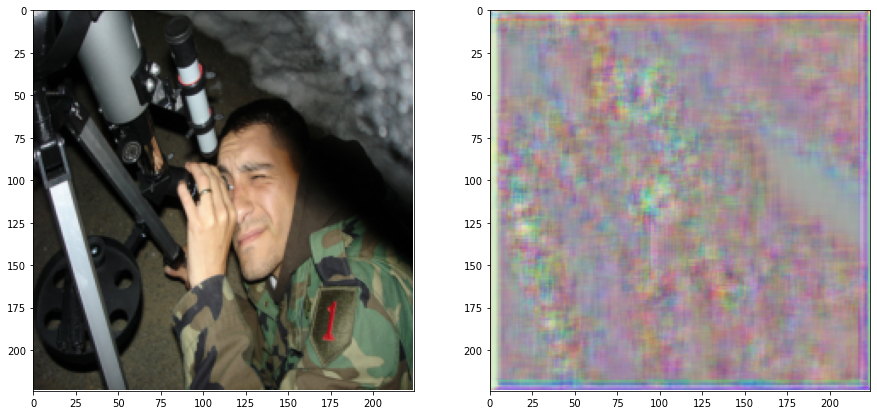

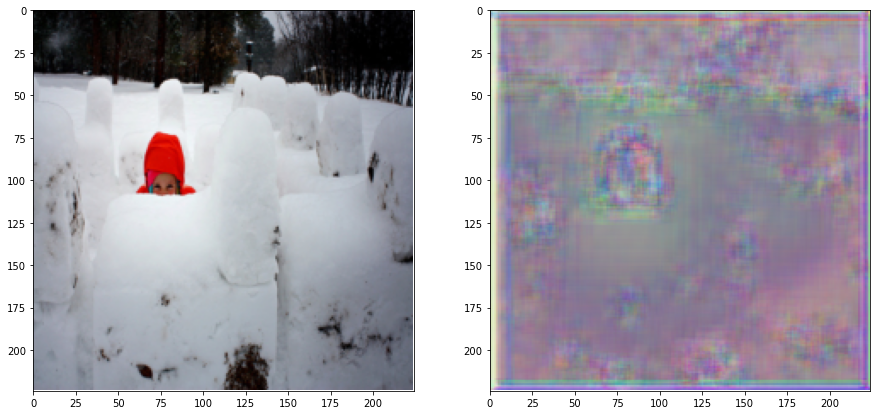

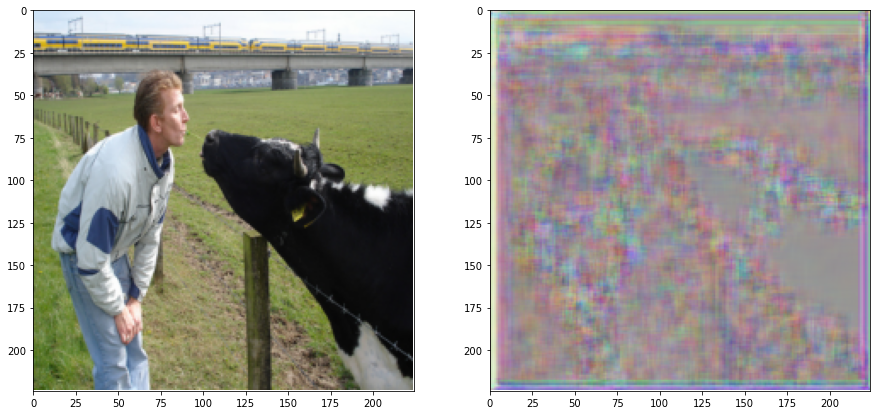

In [10]:
class ColorizationNetworkV2(nn.Module):
    def __init__(self):
        super(ColorizationNetworkV2, self).__init__()
        self.low_level_net = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256)
        )

        self.global_features_net = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(512*49, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
        )

        self.colorization_net = nn.Sequential(
            nn.Upsample(size= (56, 56), mode='nearest'),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(size= (112, 112), mode='nearest'),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(size= (224, 224), mode='nearest'),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),

        )
        self.fuse_net = nn.Sequential(
            nn.Conv2d(512, 256, 1, stride=1, padding=0),
            nn.Sigmoid()
        )
                
    def forward(self, input_batch, fused_logits):
        logits = self.low_level_net(input_batch)
        global_logits = self.global_features_net(logits)
        
        # fuse logits from the two side networks
        for i in range(logits.shape[0]):
            fused_logits[i] = torch.cat((logits[i], 
                                    global_logits[i].repeat(28, 28, 1).transpose(0,2)),
                                  dim=0)
            
        logits = self.fuse_net(fused_logits)
        logits = self.colorization_net(logits)
        #logits = logits + input_batch
    
        return torch.sigmoid(logits)
    
updated_net = ColorizationNetworkV2()

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
updated_net.to(device)
for batch, (x,y) in enumerate(train_dataloader, 1):
    fused_logits = torch.zeros(len(x), 512, 28, 28).to(device)
    log = updated_net.forward(x.to(device), fused_logits)
    for i in range(5):
        _, (axis1, axis2) = plt.subplots(1,2, figsize=(15,15))
        display_image(axis1, axis2, y[i], log[i])
    break
del updated_net
del log

In [11]:
updated_net = ColorizationNetworkV2()
learning_rate = .01
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(updated_net.parameters(), lr=learning_rate)
num_epochs = 1

model, train_loss_list, val_loss_list, train_t, val_t = training(updated_net,
                                                                 optimizer, 
                                                                 loss_fn, 
                                                                 batch_size, 
                                                                 train_dataloader, val_dataloader, 
                                                                 num_epochs, val_freq=None)

---------------------------
---- Starting training ----
---------------------------
cuda
Validation...
Evaluation in progress, batch: 199/199

Epoch 0/1:
Progress, batch 1/1590
0.07487469166517258

Progress, batch 2/1590
0.0805480107665062

Progress, batch 3/1590
0.06830519437789917

Progress, batch 4/1590
0.07497396320104599

Progress, batch 5/1590
0.05240257829427719

Progress, batch 6/1590
0.0464143268764019

Progress, batch 7/1590
0.03406408056616783

Progress, batch 8/1590
0.04612717032432556

Progress, batch 9/1590
0.03945140913128853

Progress, batch 10/1590
0.03673946484923363

Progress, batch 11/1590
0.043007638305425644

Progress, batch 12/1590
0.029167406260967255

Progress, batch 13/1590
0.03277803212404251

Progress, batch 14/1590
0.02878808043897152

Progress, batch 15/1590
0.02547742798924446

Progress, batch 16/1590
0.030465297400951385

Progress, batch 17/1590
0.029148850589990616

Progress, batch 18/1590
0.03039579652249813

Progress, batch 19/1590
0.02579253166913986

Progress, batch 176/1590
0.015353091061115265

Progress, batch 177/1590
0.017373694106936455

Progress, batch 178/1590
0.021916285157203674

Progress, batch 179/1590
0.017708193510770798

Progress, batch 180/1590
0.01530164573341608

Progress, batch 181/1590
0.021296458318829536

Progress, batch 182/1590
0.019932229071855545

Progress, batch 183/1590
0.01616685651242733

Progress, batch 184/1590
0.013160658068954945

Progress, batch 185/1590
0.016459928825497627

Progress, batch 186/1590
0.018388919532299042

Progress, batch 187/1590
0.01635953038930893

Progress, batch 188/1590
0.015774812549352646

Progress, batch 189/1590
0.014296744018793106

Progress, batch 190/1590
0.015199005603790283

Progress, batch 191/1590
0.015100954100489616

Progress, batch 192/1590
0.015581953339278698

Progress, batch 193/1590
0.01743580959737301

Progress, batch 194/1590
0.018130792304873466

Progress, batch 195/1590
0.01873253472149372

Progress, batch 196/1590
0.01456019002944231

Progress, batch 197

Progress, batch 351/1590
0.014584969729185104

Progress, batch 352/1590
0.015024589374661446

Progress, batch 353/1590
0.015008853748440742

Progress, batch 354/1590
0.017332840710878372

Progress, batch 355/1590
0.014418517239391804

Progress, batch 356/1590
0.014534569345414639

Progress, batch 357/1590
0.019801676273345947

Progress, batch 358/1590
0.015381657518446445

Progress, batch 359/1590
0.018247133120894432

Progress, batch 360/1590
0.018601587042212486

Progress, batch 361/1590
0.01459511462599039

Progress, batch 362/1590
0.017386268824338913

Progress, batch 363/1590
0.017569852992892265

Progress, batch 364/1590
0.014525065198540688

Progress, batch 365/1590
0.016086427494883537

Progress, batch 366/1590
0.014417464844882488

Progress, batch 367/1590
0.015765225514769554

Progress, batch 368/1590
0.01681824028491974

Progress, batch 369/1590
0.014956953935325146

Progress, batch 370/1590
0.012535124085843563

Progress, batch 371/1590
0.013700369745492935

Progress, batch

Progress, batch 526/1590
0.014642597176134586

Progress, batch 527/1590
0.013035174459218979

Progress, batch 528/1590
0.014107706025242805

Progress, batch 529/1590
0.010997475124895573

Progress, batch 530/1590
0.01859528198838234

Progress, batch 531/1590
0.012188751250505447

Progress, batch 532/1590
0.011593331582844257

Progress, batch 533/1590
0.017818523570895195

Progress, batch 534/1590
0.013944396749138832

Progress, batch 535/1590
0.01422022469341755

Progress, batch 536/1590
0.012101864442229271

Progress, batch 537/1590
0.011332767084240913

Progress, batch 538/1590
0.013495703227818012

Progress, batch 539/1590
0.015778440982103348

Progress, batch 540/1590
0.013639773242175579

Progress, batch 541/1590
0.014742610044777393

Progress, batch 542/1590
0.012573220767080784

Progress, batch 543/1590
0.014963102526962757

Progress, batch 544/1590
0.02001500315964222

Progress, batch 545/1590
0.016625724732875824

Progress, batch 546/1590
0.014201901853084564

Progress, batch 

Progress, batch 701/1590
0.014506136067211628

Progress, batch 702/1590
0.01645817793905735

Progress, batch 703/1590
0.014493178576231003

Progress, batch 704/1590
0.014884705655276775

Progress, batch 705/1590
0.016887396574020386

Progress, batch 706/1590
0.014690897427499294

Progress, batch 707/1590
0.014924281276762486

Progress, batch 708/1590
0.01377941109240055

Progress, batch 709/1590
0.013634666800498962

Progress, batch 710/1590
0.016699904575943947

Progress, batch 711/1590
0.011358515359461308

Progress, batch 712/1590
0.014670978300273418

Progress, batch 713/1590
0.013258129358291626

Progress, batch 714/1590
0.01907704956829548

Progress, batch 715/1590
0.02114437334239483

Progress, batch 716/1590
0.01224379613995552

Progress, batch 717/1590
0.016281133517622948

Progress, batch 718/1590
0.014941142871975899

Progress, batch 719/1590
0.01963987946510315

Progress, batch 720/1590
0.01470663957297802

Progress, batch 721/1590
0.01922369748353958

Progress, batch 722/1

Progress, batch 876/1590
0.011028875596821308

Progress, batch 877/1590
0.014659211970865726

Progress, batch 878/1590
0.010240959003567696

Progress, batch 879/1590
0.013929852284491062

Progress, batch 880/1590
0.01877116970717907

Progress, batch 881/1590
0.014569785445928574

Progress, batch 882/1590
0.012619608081877232

Progress, batch 883/1590
0.013279350474476814

Progress, batch 884/1590
0.013199646025896072

Progress, batch 885/1590
0.011158929206430912

Progress, batch 886/1590
0.014542369171977043

Progress, batch 887/1590
0.010760682635009289

Progress, batch 888/1590
0.014338620007038116

Progress, batch 889/1590
0.013842013664543629

Progress, batch 890/1590
0.011095460504293442

Progress, batch 891/1590
0.01331361848860979

Progress, batch 892/1590
0.011593293398618698

Progress, batch 893/1590
0.010992353782057762

Progress, batch 894/1590
0.01431211642920971

Progress, batch 895/1590
0.012064171023666859

Progress, batch 896/1590
0.011233152821660042

Progress, batch 

Progress, batch 1050/1590
0.012640843167901039

Progress, batch 1051/1590
0.01205932255834341

Progress, batch 1052/1590
0.011217246763408184

Progress, batch 1053/1590
0.009326659142971039

Progress, batch 1054/1590
0.01406957022845745

Progress, batch 1055/1590
0.016283517703413963

Progress, batch 1056/1590
0.011936240829527378

Progress, batch 1057/1590
0.014736628159880638

Progress, batch 1058/1590
0.010615771636366844

Progress, batch 1059/1590
0.013251634314656258

Progress, batch 1060/1590
0.017902255058288574

Progress, batch 1061/1590
0.012767026200890541

Progress, batch 1062/1590
0.01709466427564621

Progress, batch 1063/1590
0.014865568839013577

Progress, batch 1064/1590
0.014072173275053501

Progress, batch 1065/1590
0.011392992921173573

Progress, batch 1066/1590
0.012283849529922009

Progress, batch 1067/1590
0.011695722118020058

Progress, batch 1068/1590
0.015042546205222607

Progress, batch 1069/1590
0.012507786974310875

Progress, batch 1070/1590
0.012250422500073

Progress, batch 1221/1590
0.01598762534558773

Progress, batch 1222/1590
0.010772769339382648

Progress, batch 1223/1590
0.015715954825282097

Progress, batch 1224/1590
0.012616260908544064

Progress, batch 1225/1590
0.011966132558882236

Progress, batch 1226/1590
0.013900785706937313

Progress, batch 1227/1590
0.01077728345990181

Progress, batch 1228/1590
0.012505539692938328

Progress, batch 1229/1590
0.012151752598583698

Progress, batch 1230/1590
0.014543789438903332

Progress, batch 1231/1590
0.013447445817291737

Progress, batch 1232/1590
0.010689514689147472

Progress, batch 1233/1590
0.011773550882935524

Progress, batch 1234/1590
0.011016877368092537

Progress, batch 1235/1590
0.011252230033278465

Progress, batch 1236/1590
0.013579871505498886

Progress, batch 1237/1590
0.015904830768704414

Progress, batch 1238/1590
0.014568372629582882

Progress, batch 1239/1590
0.011959587223827839

Progress, batch 1240/1590
0.012727709487080574

Progress, batch 1241/1590
0.01609555631875

Progress, batch 1392/1590
0.009590084664523602

Progress, batch 1393/1590
0.013734281063079834

Progress, batch 1394/1590
0.014748440124094486

Progress, batch 1395/1590
0.010790972039103508

Progress, batch 1396/1590
0.01298756804317236

Progress, batch 1397/1590
0.0119047025218606

Progress, batch 1398/1590
0.012999706901609898

Progress, batch 1399/1590
0.014469551853835583

Progress, batch 1400/1590
0.014868243597447872

Progress, batch 1401/1590
0.01259371917694807

Progress, batch 1402/1590
0.01312363799661398

Progress, batch 1403/1590
0.010213175788521767

Progress, batch 1404/1590
0.012517891824245453

Progress, batch 1405/1590
0.011004016734659672

Progress, batch 1406/1590
0.011284209787845612

Progress, batch 1407/1590
0.012466475367546082

Progress, batch 1408/1590
0.018386313691735268

Progress, batch 1409/1590
0.013323702849447727

Progress, batch 1410/1590
0.009793423116207123

Progress, batch 1411/1590
0.012376229278743267

Progress, batch 1412/1590
0.01555478479713201

Progress, batch 1563/1590
0.016871454194188118

Progress, batch 1564/1590
0.013770350255072117

Progress, batch 1565/1590
0.010378915816545486

Progress, batch 1566/1590
0.011948703788220882

Progress, batch 1567/1590
0.017248526215553284

Progress, batch 1568/1590
0.012724490836262703

Progress, batch 1569/1590
0.01036035642027855

Progress, batch 1570/1590
0.01390778087079525

Progress, batch 1571/1590
0.011522671207785606

Progress, batch 1572/1590
0.014759973622858524

Progress, batch 1573/1590
0.01270204409956932

Progress, batch 1574/1590
0.011634196154773235

Progress, batch 1575/1590
0.013247810304164886

Progress, batch 1576/1590
0.013936230912804604

Progress, batch 1577/1590
0.009753456339240074

Progress, batch 1578/1590
0.009243065491318703

Progress, batch 1579/1590
0.012392895296216011

Progress, batch 1580/1590
0.014087534509599209

Progress, batch 1581/1590
0.01459113135933876

Progress, batch 1582/1590
0.012177867814898491

Progress, batch 1583/1590
0.0154985468834638

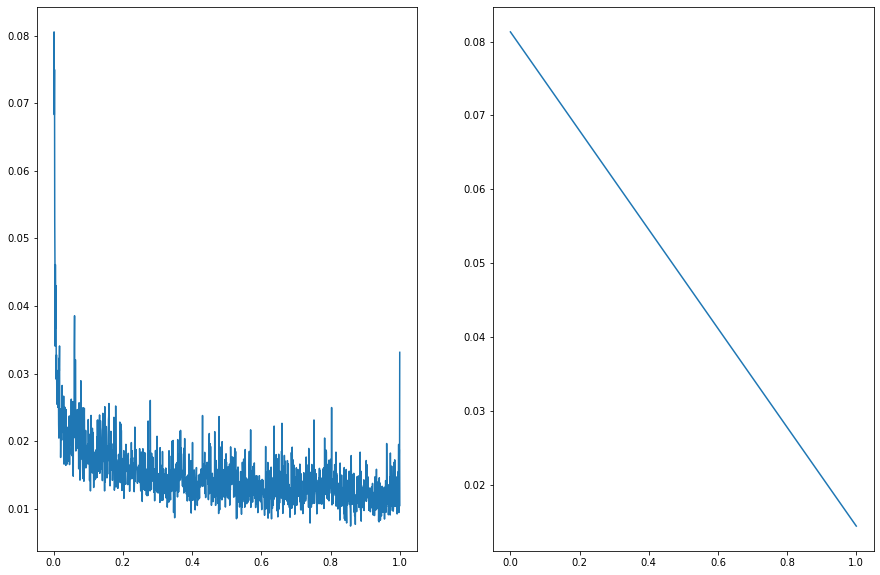

In [12]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.plot(train_t, train_loss_list)
ax2.plot(val_t, val_loss_list)
plt.show()

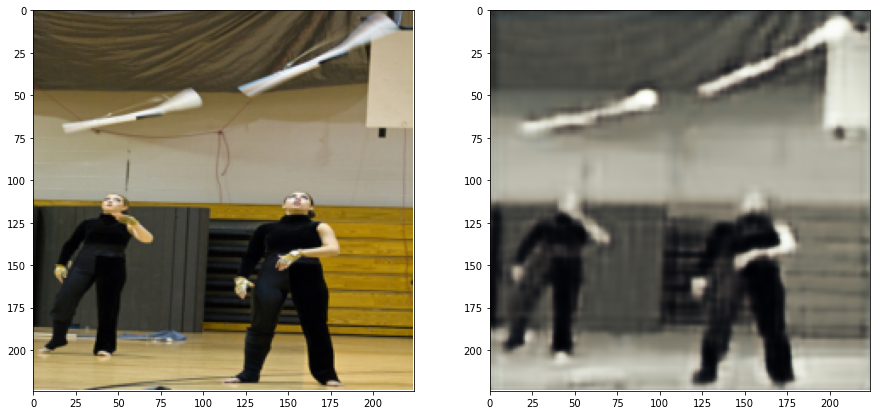

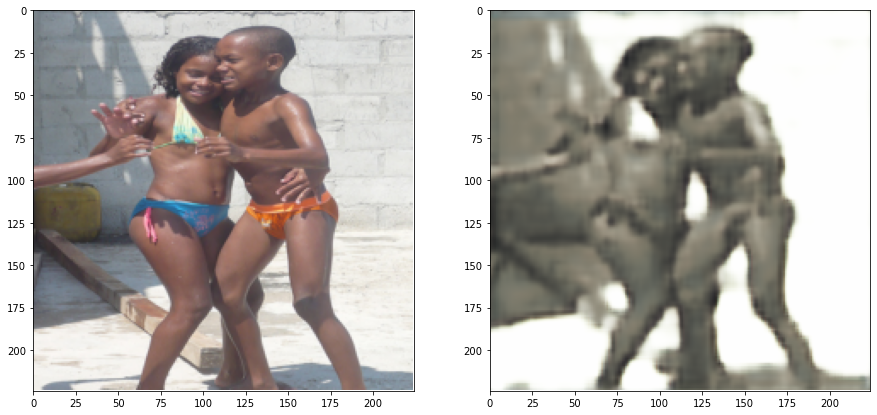

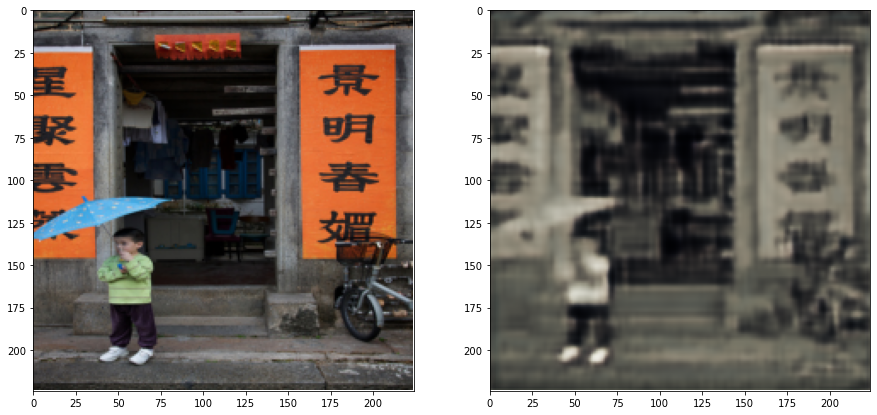

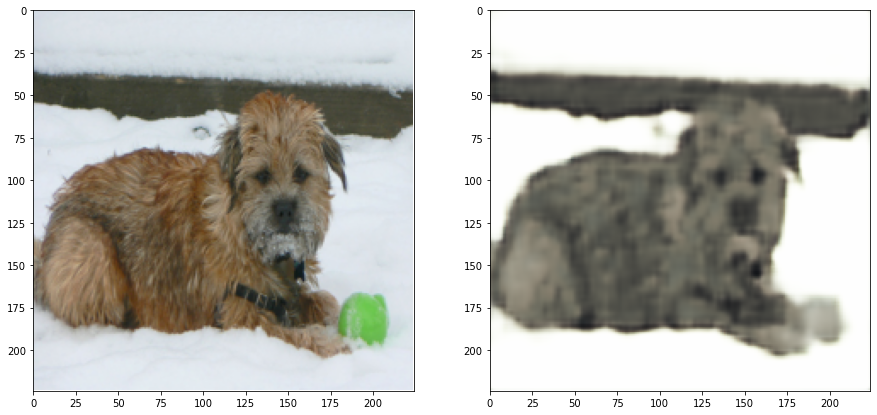

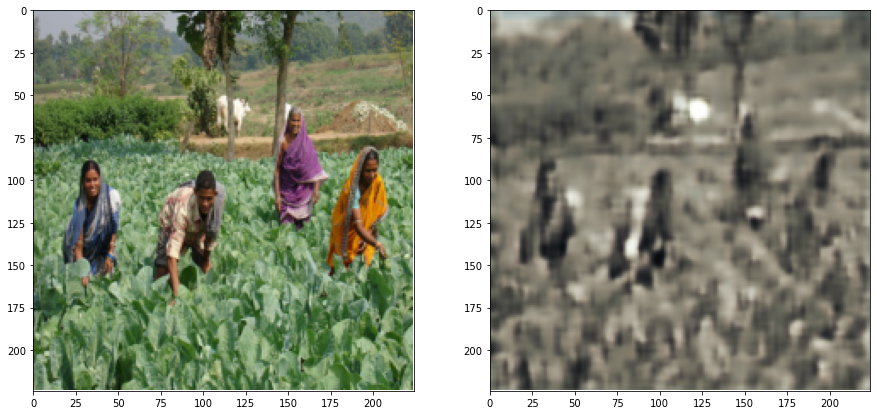

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for batch, (x,y) in enumerate(train_dataloader, 1):
    fused_logits = torch.zeros(len(x), 512, 28, 28).to(device)
    log = updated_net.forward(x.to(device), fused_logits)
    for i in range(5):
        _, (axis1, axis2) = plt.subplots(1,2, figsize=(15,15))
        display_image(axis1, axis2, y[i], log[i])
    break